In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import torch

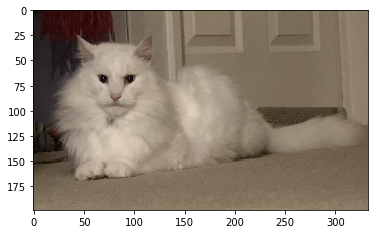

In [2]:
image = Image.open("data/cat.png")
imshow(image)

In [3]:
## Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [4]:
tensor = preprocess(image)


In [5]:
prediction_var = Variable(tensor.unsqueeze(0), requires_grad=True)

In [6]:
model = models.resnet18(pretrained=True)

In [7]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [8]:
# Attach a hook to any model (or any part of a model - here we grab the final convnet layer in 
# ResNet18) which will save the activate features as an instance variable. 

class SaveFeatures():
    
    features = None
    
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = (output.data).numpy()
    
    def remove(self):
        self.hook.remove()

In [9]:
final_layer = model._modules.get('layer4')


In [10]:
activated_features = SaveFeatures(final_layer)

In [11]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()
activated_features.remove()


In [12]:
topk(pred_probabilities, 1)

(tensor([0.9181]), tensor([283]))

In [13]:
# source: http://cnnlocalization.csail.mit.edu/

# Having made the guess, let's see where the neural network is focussing its attention. 
# The getCAM() method here takes the activated features of the convnet, the weights of the 
# fully-connected layer, and the class index we want to investivate. 
# We index into the fully-connected layer to get the weights for that class and 
# calculate the dot product with our features from the image. 

def get_CAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    
    cam = cam.reshape(h,w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    
    return [cam_img]

In [14]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

In [15]:
class_idx = topk(pred_probabilities, 1)[1].int()

In [16]:
overlay = get_CAM(activated_features.features, weight_softmax, class_idx)

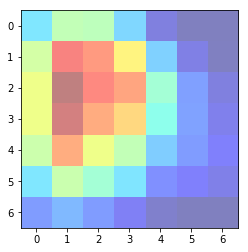

In [17]:
imshow(overlay[0], alpha=0.5, cmap='jet')

/home/notebook/miniconda3/envs/py3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


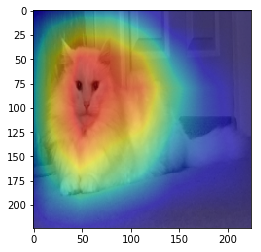

In [18]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3], mode='constant'), alpha=0.5, cmap='jet')

In [19]:
# We can also look at the models' second choice for Casper

In [20]:
class_idx = topk(pred_probabilities, 2)[1].int()
class_idx

tensor([283, 332], dtype=torch.int32)

In [21]:
overlay = get_CAM(activated_features.features, weight_softmax, 332)

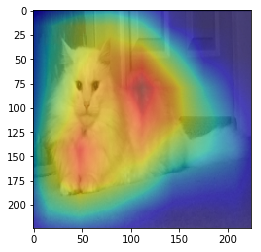

In [22]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3], mode='constant'), alpha=0.5, cmap='jet')